# WESAD - Clasificación de Estrés
## Análisis Completo con Buenas Prácticas de Machine Learning

Este notebook contiene el análisis completo del dataset WESAD (Wearable Stress and Affect Detection).

### Buenas Prácticas Implementadas

- Sin Data Leakage - Split antes de Scaling
- Manejo de Desbalance de Clases - class_weight='balanced' + SMOTE
- Cross-Validation - StratifiedKFold (5-fold)
- Pipelines de sklearn - Preprocesamiento encapsulado
- Evaluación Completa - Múltiples métricas
- Detección de Overfitting - Comparación train vs test

---

**Autor:** Proyecto WESAD - Samsung  
**Fecha:** Diciembre 2025

## Paso 1: Instalación de Dependencias

In [ ]:
# Celda 1: Instalación de Dependencias (ACTUALIZADA)

print("Instalando dependencias necesarias...\n")

# Lista de paquetes a instalar
packages = {
    'kagglehub': 'kagglehub',
    'xgboost': 'xgboost',
    'imbalanced-learn': 'imblearn',
    'scikit-learn': 'sklearn',
    'scipy': 'scipy',
    'seaborn': 'seaborn'
}

import importlib
import subprocess
import sys

for package_name, import_name in packages.items():
    try:
        importlib.import_module(import_name.split('.')[0])
        print(f"✅ {package_name} ya está instalado")
    except ImportError:
        print(f"📥 Instalando {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        print(f"✅ {package_name} instalado correctamente")

print("\nTodas las dependencias están listas!")

Instalando dependencias necesarias...

✅ kagglehub ya está instalado
📥 Instalando xgboost...
✅ xgboost instalado correctamente
📥 Instalando imbalanced-learn...
✅ imbalanced-learn instalado correctamente
✅ scikit-learn ya está instalado
✅ scipy ya está instalado
✅ seaborn ya está instalado

Todas las dependencias están listas!


## Imports

In [ ]:
# Celda de Imports - ACTUALIZADA

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from scipy.signal import resample

# Sklearn - AGREGADO cross_validate
from sklearn.model_selection import (train_test_split, cross_val_score, cross_validate,
                                      StratifiedKFold, learning_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, ConfusionMatrixDisplay,
                             RocCurveDisplay, roc_curve, auc)

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Kaggle
import kagglehub
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("Imports completados")

Imports completados


## Configuración

In [ ]:
CONFIG = {
    # Datos
    'subjects': ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9",
                 "S10", "S11", "S13", "S14", "S15", "S16", "S17"],
    'sampling_rate_hz': 700,
    'window_seconds': 1,

    # Características
    'features_physiological': ['bvp', 'eda', 'temp'],
    'features_accelerometer': ['acc_x', 'acc_y', 'acc_z'],

    # Entrenamiento
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5,

    # Modelos
    'rf_params': {
        'n_estimators': 100,
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced'
    },
    'xgb_params': {
        'n_estimators': 100,
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
}

print("Configuración cargada")

Configuración cargada


## Sección 1: Funciones de Carga de Datos

In [ ]:
###################
# Funcion: load_subject
# Parametros: subject (str) - Identificador del sujeto a cargar
# Salida: DataFrame con las señales procesadas del sujeto
# Proposito: Carga y procesa las señales fisiológicas de un sujeto específico del dataset WESAD
###################
def load_subject(subject):
    """Carga un sujeto del dataset WESAD y procesa sus señales."""
    print(f"Procesando {subject}...")

    path = kagglehub.dataset_download(
        "orvile/wesad-wearable-stress-affect-detection-dataset",
        f"WESAD/{subject}/{subject}.pkl"
    )

    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    # Señales del reloj
    acc = np.array(data["signal"]["wrist"]["ACC"])
    bvp = np.array(data["signal"]["wrist"]["BVP"]).squeeze()
    eda = np.array(data["signal"]["wrist"]["EDA"]).squeeze()
    temp = np.array(data["signal"]["wrist"]["TEMP"]).squeeze()
    labels = np.array(data["label"])

    L = len(labels)

    # Re-sample a 700Hz
    acc_rs = resample(acc, L)
    bvp_rs = resample(bvp, L)
    eda_rs = resample(eda, L)
    temp_rs = resample(temp, L)

    # Etiqueta binaria: 0=no estrés, 1=estrés
    stress_bin = np.where(labels == 2, 1, 0)

    return pd.DataFrame({
        "subject": subject,
        "acc_x": acc_rs[:, 0],
        "acc_y": acc_rs[:, 1],
        "acc_z": acc_rs[:, 2],
        "bvp": bvp_rs,
        "eda": eda_rs,
        "temp": temp_rs,
        "stress": stress_bin
    })


###################
# Funcion: load_all_subjects
# Parametros: subjects (list, opcional) - Lista de sujetos a cargar, usa CONFIG si None
# Salida: DataFrame combinado con datos de todos los sujetos
# Proposito: Carga y combina los datos de múltiples sujetos del dataset WESAD
###################
def load_all_subjects(subjects=None):
    """Carga y combina múltiples sujetos."""
    if subjects is None:
        subjects = CONFIG['subjects']

    print(f"\nCargando {len(subjects)} sujetos...")

    all_dfs = []
    for sbj in subjects:
        try:
            df = load_subject(sbj)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error en {sbj}: {e}")

    df_full = pd.concat(all_dfs, ignore_index=True)
    print(f"\nDataset: {df_full.shape}")
    return df_full


def window_reduce(df, hz=700, window_seconds=1):
    """Reduce dataset aplicando ventanas."""
    window = hz * window_seconds
    df_num = df.select_dtypes(include=[np.number])
    usable = (len(df_num) // window) * window
    df_num = df_num.iloc[:usable]
    df_windowed = df_num.groupby(df_num.index // window).mean()
    df_windowed["stress"] = df_num["stress"].groupby(df_num.index // window).max()
    return df_windowed

print("Funciones de carga definidas")

Funciones de carga definidas


## Sección 2: Validaciones de ML (Buenas Prácticas)

In [ ]:
class MLValidator:
    """Validador de buenas prácticas de ML."""

    ###################
    # Metodo: check_class_imbalance
    # Parametros: y (array o Series) - Etiquetas de clase, threshold (float, opcional) - Umbral para considerar desbalance
    # Salida: dict - Informacion sobre el balance de clases
    # Proposito: Detectar si existe desbalance de clases en el dataset
    ###################
    @staticmethod
    def check_class_imbalance(y, threshold=0.3):
        """Detecta desbalance de clases."""
        value_counts = y.value_counts() if isinstance(y, pd.Series) else pd.Series(*np.unique(y, return_counts=True)[::-1])
        proportions = value_counts / len(y)
        min_proportion = proportions.min()

        print("\nBalance de Clases:")
        for cls, count in value_counts.items():
            print(f"   Clase {cls}: {count:,} ({proportions[cls]:.2%})")

        if min_proportion < threshold:
            print(f"\nDESBALANCE: {min_proportion:.2%}")
            print("   → Usar class_weight='balanced' o SMOTE")
        else:
            print(f"\nBalanceado")

        return {'is_imbalanced': min_proportion < threshold, 'min_proportion': min_proportion}

    ###################
    # Metodo: check_missing_values
    # Parametros: df (DataFrame) - Dataset a verificar
    # Salida: Series - Valores faltantes por columna
    # Proposito: Verificar la presencia de valores faltantes en el dataset
    ###################
    @staticmethod
    def check_missing_values(df):
        """Verifica valores faltantes."""
        missing = df.isnull().sum()[df.isnull().sum() > 0]
        if len(missing) > 0:
            print("\nValores faltantes:")
            print(missing)
        else:
            print("\nSin valores faltantes")
        return missing


###################
# Funcion: validate_dataset
# Parametros: df (DataFrame) - Dataset a validar, target_col (str, opcional) - Nombre de la columna objetivo
# Salida: None - Ejecuta validaciones sobre el dataset
# Proposito: Ejecutar validaciones completas sobre el dataset para asegurar calidad de datos
###################
def validate_dataset(df, target_col='stress'):
    """Ejecuta validaciones sobre el dataset."""
    print("\n" + "="*80)
    print("VALIDACIÓN DEL DATASET")
    print("="*80)

    validator = MLValidator()
    validator.check_missing_values(df)
    validator.check_class_imbalance(df[target_col])

    print("\n" + "="*80)
    print("VALIDACIÓN COMPLETADA")
    print("="*80)

print("Funciones de validación definidas")

Funciones de validación definidas


## Sección 3: Funciones de Entrenamiento y Evaluación

**CORRECCIÓN CRÍTICA:** Split ANTES de escalar (prevenir data leakage)

In [ ]:
def split_and_scale_data(X, y, test_size=0.2, random_state=42):
    """
    CORRECCIÓN CRÍTICA: Split PRIMERO, luego escalar

    ANTES (MAL):
    X_scaled = scaler.fit_transform(X)  # ❌ Ajusta scaler con TODOS los datos
    X_train, X_test = train_test_split(X_scaled)  # ❌ Data leakage

    AHORA (BIEN):
    X_train, X_test = train_test_split(X)  # ✅ Split primero
    scaler.fit(X_train)  # ✅ Solo aprende de train
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    """
    # 1️⃣ SPLIT PRIMERO
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 2️⃣ ESCALAR DESPUÉS (fit solo en train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


def get_models(X_train, y_train, use_smote=False, scale_pos_weight_aggressive=False):
    """Retorna pipelines con hiperparámetros optimizados para diferentes estrategias."""
    # Calcular scale_pos_weight
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

    models = {}

    if use_smote:
        # MODELO 1: Con SMOTE + Hiperparámetros Balanceados
        models['SMOTE + Balanced'] = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42, k_neighbors=3)),  # Menos vecinos para SMOTE
            ('classifier', XGBClassifier(
                n_estimators=200,              # Más árboles
                max_depth=6,                   # Menos profundidad (prevenir overfitting)
                learning_rate=0.05,            # Learning rate más bajo
                min_child_weight=1,            # Menos restrictivo
                gamma=0.1,                     # Regularización suave
                subsample=0.8,                 # Submuestreo para robustez
                colsample_bytree=0.8,          # Feature sampling
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss'
            ))
        ])

        # MODELO 3: Con SMOTE + Max Delta Step (para datasets desbalanceados)
        models['SMOTE + Delta Step'] = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('classifier', XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                min_child_weight=1,
                gamma=0.1,
                max_delta_step=5,              # Ayuda con clases desbalanceadas
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss'
            ))
        ])
    else:
        if scale_pos_weight_aggressive:
            # MODELO 2: Sin SMOTE + Scale Pos Weight Agresivo
            models['Scale Weight Agresivo'] = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', XGBClassifier(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    min_child_weight=1,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=scale_pos_weight * 1.5,  # Aumentar peso de clase minoritaria
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='logloss'
                ))
            ])
        else:
            # Modelo básico con scale_pos_weight
            models['Scale Weight'] = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', XGBClassifier(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    min_child_weight=1,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=scale_pos_weight,
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='logloss'
                ))
            ])

    return models


def create_pipeline(model, use_smote=False):
    """Crea pipeline con StandardScaler y opcionalmente SMOTE."""
    steps = [('scaler', StandardScaler())]

    if use_smote:
        steps.append(('smote', SMOTE(random_state=42)))
        steps.append(('classifier', model))
        return ImbPipeline(steps)
    else:
        steps.append(('classifier', model))
        return Pipeline(steps)


def cross_validate_model(model, X, y, cv=5):
    """Validación cruzada estratificada."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=True)

    results = {}
    for metric in scoring:
        train_scores = scores[f'train_{metric}']
        test_scores = scores[f'test_{metric}']
        results[metric] = {
            'train_mean': train_scores.mean(),
            'train_std': train_scores.std(),
            'test_mean': test_scores.mean(),
            'test_std': test_scores.std(),
            'overfitting': train_scores.mean() - test_scores.mean()
        }

    return results


def evaluate_model(model, X_test, y_test):
    """Evalúa modelo con múltiples métricas."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    return results, y_pred, y_proba

print("Funciones de entrenamiento definidas")

Funciones de entrenamiento definidas


## Sección 4: Visualización

In [ ]:
###################
# Funcion: plot_confusion_matrix
# Parametros: cm (array) - Matriz de confusion, title (str, opcional) - Titulo del grafico
# Salida: None - Muestra el grafico de matriz de confusion
# Proposito: Visualizar la matriz de confusion para evaluar el rendimiento del modelo
###################
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    """Plotea matriz de confusión."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


###################
# Funcion: plot_roc_curve
# Parametros: y_test (array) - Etiquetas reales, y_proba (array) - Probabilidades predichas, title (str, opcional) - Titulo del grafico
# Salida: None - Muestra la curva ROC
# Proposito: Visualizar la curva ROC para evaluar la capacidad de discriminacion del modelo
###################
def plot_roc_curve(y_test, y_proba, title='ROC Curve'):
    """Plotea curva ROC."""
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


###################
# Funcion: plot_metrics_comparison
# Parametros: results_dict (dict) - Diccionario con resultados de diferentes modelos
# Salida: None - Muestra grafico comparativo de metricas
# Proposito: Comparar las metricas de rendimiento entre diferentes modelos
###################
def plot_metrics_comparison(results_dict):
    """Compara métricas entre modelos."""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    models = list(results_dict.keys())

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.35

    for i, (model_name, results) in enumerate(results_dict.items()):
        values = [results.get(m, 0) for m in metrics]
        ax.bar(x + i*width, values, width, label=model_name)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Model Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


###################
# Funcion: plot_cross_validation_results
# Parametros: cv_results (dict) - Resultados de validacion cruzada
# Salida: None - Muestra grafico de resultados de cross-validation
# Proposito: Visualizar los resultados de validacion cruzada para detectar overfitting
###################
def plot_cross_validation_results(cv_results):
    """Visualiza resultados de cross-validation."""
    metrics = list(cv_results.keys())
    train_means = [cv_results[m]['train_mean'] for m in metrics]
    test_means = [cv_results[m]['test_mean'] for m in metrics]
    test_stds = [cv_results[m]['test_std'] for m in metrics]

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35

    ax.bar(x - width/2, train_means, width, label='Train', color='skyblue')
    ax.bar(x + width/2, test_means, width, yerr=test_stds, label='Test (CV)',
           color='orange', capsize=5)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Cross-Validation Results', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Funciones de visualización definidas")

Funciones de visualización definidas


## Sección 4.5: Análisis de Overfitting

In [ ]:
# Celda: Sección 4.5 - Análisis de Overfitting (CON OPCIÓN)

###################
# Funcion: analyze_overfitting
# Parametros: model (estimator) - Modelo entrenado, model_name (str) - Nombre del modelo, X_train (array) - Datos de entrenamiento, X_test (array) - Datos de prueba, y_train (array) - Etiquetas de entrenamiento, y_test (array) - Etiquetas de prueba, include_learning_curves (bool, opcional) - Si incluir curvas de aprendizaje
# Salida: dict - Resultados del analisis de overfitting
# Proposito: Analizar si el modelo presenta overfitting comparando metricas de train vs test
###################
def analyze_overfitting(model, model_name, X_train, X_test, y_train, y_test,
                       include_learning_curves=False):  # ← Parámetro nuevo
    """
    Análisis detallado de overfitting con comparación train vs test.

    Parámetros:
    -----------
    model : estimator
        Modelo entrenado de sklearn
    model_name : str
        Nombre del modelo para visualización
    X_train, X_test : array
        Datos de entrenamiento y prueba
    y_train, y_test : array
        Etiquetas de entrenamiento y prueba
    include_learning_curves : bool, default=False
        Si True, genera learning curves (LENTO). Si False, solo métricas.
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISIS DE OVERFITTING - {model_name}")
    print(f"{'='*80}")

    # 1. Métricas en Train vs Test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else None
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    train_scores = [
        accuracy_score(y_train, y_train_pred),
        precision_score(y_train, y_train_pred, zero_division=0),
        recall_score(y_train, y_train_pred, zero_division=0),
        f1_score(y_train, y_train_pred, zero_division=0),
        roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None
    ]
    test_scores = [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred, zero_division=0),
        recall_score(y_test, y_test_pred, zero_division=0),
        f1_score(y_test, y_test_pred, zero_division=0),
        roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    ]

    # Tabla de comparación
    comparison_df = pd.DataFrame({
        'Métrica': metrics,
        'Train': [f"{s:.4f}" if s is not None else "N/A" for s in train_scores],
        'Test': [f"{s:.4f}" if s is not None else "N/A" for s in test_scores],
        'Diferencia': [f"{(t - te):.4f}" if t and te else "N/A" for t, te in zip(train_scores, test_scores)]
    })

    print(f"\nMétricas Train vs Test:")
    print(comparison_df.to_string(index=False))

    # Diagnóstico
    print(f"\nDiagnóstico de Overfitting:")
    for i, metric in enumerate(metrics):
        if train_scores[i] is not None and test_scores[i] is not None:
            diff = train_scores[i] - test_scores[i]
            if diff > 0.1:
                print(f"   {metric}: Posible OVERFITTING (diferencia: {diff:.4f})")
            elif diff < -0.05:
                print(f"   {metric}: Posible UNDERFITTING (diferencia: {diff:.4f})")
            else:
                print(f"   {metric}: Buen ajuste (diferencia: {diff:.4f})")

    # VISUALIZACIÓN
    if include_learning_curves:
        # Learning Curves (LENTO - solo si se solicita)
        print(f"\nGenerando Learning Curves (esto puede tardar)...")

        from sklearn.model_selection import learning_curve

        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores_lc, test_scores_lc = learning_curve(
            model, X_train, y_train,
            train_sizes=train_sizes,
            cv=5,
            scoring='f1',
            n_jobs=-1,
            random_state=42
        )

        # Visualización con learning curve
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # 1. Learning Curve
        train_mean = np.mean(train_scores_lc, axis=1)
        train_std = np.std(train_scores_lc, axis=1)
        test_mean = np.mean(test_scores_lc, axis=1)
        test_std = np.std(test_scores_lc, axis=1)

        axes[0].plot(train_sizes_abs, train_mean, 'o-', color='r', label='Train Score', linewidth=2)
        axes[0].fill_between(train_sizes_abs, train_mean - train_std,
                              train_mean + train_std, alpha=0.1, color='r')
        axes[0].plot(train_sizes_abs, test_mean, 'o-', color='g', label='CV Score', linewidth=2)
        axes[0].fill_between(train_sizes_abs, test_mean - test_std,
                              test_mean + test_std, alpha=0.1, color='g')
        axes[0].set_xlabel('Training Size', fontweight='bold', fontsize=12)
        axes[0].set_ylabel('F1-Score', fontweight='bold', fontsize=12)
        axes[0].set_title(f'Learning Curve - {model_name}', fontweight='bold', fontsize=14)
        axes[0].legend(loc='best')
        axes[0].grid(alpha=0.3)

        # 2. Train vs Test Metrics
        x = np.arange(len(metrics))
        width = 0.35

        train_vals = [s if s is not None else 0 for s in train_scores]
        test_vals = [s if s is not None else 0 for s in test_scores]

        axes[1].bar(x - width/2, train_vals, width, label='Train', color='skyblue')
        axes[1].bar(x + width/2, test_vals, width, label='Test', color='orange')
        axes[1].set_xlabel('Métricas', fontweight='bold', fontsize=12)
        axes[1].set_ylabel('Score', fontweight='bold', fontsize=12)
        axes[1].set_title(f'Train vs Test Metrics - {model_name}', fontweight='bold', fontsize=14)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(metrics, rotation=45, ha='right')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].set_ylim([0, 1.1])

    else:
        # Solo gráfico de barras (RÁPIDO)
        print(f"\nGenerando gráfico comparativo (learning curves desactivadas)...")

        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(len(metrics))
        width = 0.35

        train_vals = [s if s is not None else 0 for s in train_scores]
        test_vals = [s if s is not None else 0 for s in test_scores]

        bars1 = ax.bar(x - width/2, train_vals, width, label='Train', color='skyblue', alpha=0.8)
        bars2 = ax.bar(x + width/2, test_vals, width, label='Test', color='orange', alpha=0.8)

        # Valores en barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax.set_xlabel('Métricas', fontweight='bold', fontsize=12)
        ax.set_ylabel('Score', fontweight='bold', fontsize=12)
        ax.set_title(f'Train vs Test Metrics - {model_name}', fontweight='bold', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.1])

    plt.tight_layout()
    plt.show()

    return {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'comparison_df': comparison_df
    }

print("Función de análisis de overfitting definida (learning curves opcionales)")

Función de análisis de overfitting definida (learning curves opcionales)


## Sección 5: Pipeline Completo de Evaluación

In [ ]:
def run_evaluation_pipeline(df, target_col='stress', features=None, use_smote=False, perform_cv=True, include_learning_curves=False, save_best_model=False, test_cases=None):
    """
    Pipeline completo de evaluación con buenas prácticas de ML.

    Parámetros:
    -----------
    df : DataFrame
        Dataset completo con todas las características
    target_col : str, default='stress'
        Nombre de la columna objetivo
    features : list, opcional
        Lista de características a usar para el entrenamiento.
        Si es None, usa todas las columnas excepto 'subject' y target_col.
    use_smote : bool, default=False
        Si True, aplica SMOTE para balancear clases
    perform_cv : bool, default=True
        Si True, realiza validación cruzada (5-fold)
    include_learning_curves : bool, default=False
        Si True, genera curvas de aprendizaje (puede ser lento)
    save_best_model : bool, default=False
        Si True, guarda el mejor modelo encontrado
    test_cases : list, opcional
        Lista de casos de prueba para evaluación final

    Retorna:
    --------
    dict : Resultados de evaluación para cada modelo
    dict : Modelos entrenados para cada modelo
    str : Nombre del mejor modelo (si save_best_model=True)
    """
    print("\n" + "="*80)
    print("INICIANDO PIPELINE DE EVALUACIÓN")
    print("="*80)

    # 1. Validar dataset
    validate_dataset(df, target_col)

    # 2. Preparar datos - SELECCIÓN DE CARACTERÍSTICAS
    if features is None:
        cols_to_drop = [target_col]
        if 'subject' in df.columns:
            cols_to_drop.append('subject')
        X = df.drop(columns=cols_to_drop)
        print(f"\nUsando TODAS las características disponibles:")
        print(f"   Características automáticas (sin 'subject' y '{target_col}')")
    else:
        missing_features = [f for f in features if f not in df.columns]
        if missing_features:
            raise ValueError(f"Características no encontradas: {missing_features}")

        X = df[features]
        print(f"\nUsando características SELECCIONADAS:")
        print(f"   Características especificadas manualmente")

    print(f"\n   Features: {list(X.columns)}")
    print(f"   Total: {len(X.columns)} características")

    # Mostrar categorías
    physiological = [f for f in X.columns if f in ['bvp', 'eda', 'temp']]
    accelerometer = [f for f in X.columns if f in ['acc_x', 'acc_y', 'acc_z']]

    if physiological:
        print(f"   Fisiológicas: {physiological}")
    if accelerometer:
        print(f"   Acelerómetro: {accelerometer}")

    y = df[target_col]

    # 3. Split y escalar (CORRECTO: split primero)
    X_train, X_test, y_train, y_test, scaler = split_and_scale_data(X, y)

    print(f"\nTamaño del dataset:")
    print(f"   Train: {X_train.shape[0]:,} muestras")
    print(f"   Test:  {X_test.shape[0]:,} muestras")

    # 4. Obtener modelos - TODOS LOS MODELOS OPTIMIZADOS
    print(f"\nConfigurando modelos con hiperparámetros optimizados...")
    models = get_models(X_train, y_train, use_smote=True)  # Incluir todos los modelos optimizados
    models.update(get_models(X_train, y_train, use_smote=False, scale_pos_weight_aggressive=True))

    all_results = {}
    all_trained_pipelines = {}

    for model_name, pipeline in models.items():
        print(f"\n{'='*80}")
        print(f"Modelo: {model_name}")
        print(f"{'='*80}")

        # Cross-validation
        if perform_cv:
            print("\nCross-Validation...")
            cv_results = cross_validate_model(pipeline, X_train, y_train)

            print("\nResultados CV:")
            for metric, scores in cv_results.items():
                print(f"   {metric.upper()}:")
                print(f"      Train: {scores['train_mean']:.4f} (±{scores['train_std']:.4f})")
                print(f"      Test:  {scores['test_mean']:.4f} (±{scores['test_std']:.4f})")

                if scores['overfitting'] > 0.1:
                    print(f"      Overfitting detectado: {scores['overfitting']:.4f}")

            plot_cross_validation_results(cv_results)

        # Entrenar en train completo
        print("\nEntrenando en train completo...")
        pipeline.fit(X_train, y_train)
        all_trained_pipelines[model_name] = pipeline # Guardar el pipeline entrenado

        # Evaluar en test
        print("\nEvaluando en test...")
        results, y_pred, y_proba = evaluate_model(pipeline, X_test, y_test)

        print(f"\nResultados en Test:")
        print(f"   Accuracy:  {results['accuracy']:.4f}")
        print(f"   Precision: {results['precision']:.4f}")
        print(f"   Recall:    {results['recall']:.4f}")
        print(f"   F1-Score:  {results['f1']:.4f}")
        if results['roc_auc']:
            print(f"   ROC-AUC:   {results['roc_auc']:.4f}")

        print(f"\nClassification Report:")
        print(results['classification_report'])

        # Visualizar
        plot_confusion_matrix(results['confusion_matrix'],
                            title=f'Confusion Matrix - {model_name}')

        if y_proba is not None:
            plot_roc_curve(y_test, y_proba,
                          title=f'ROC Curve - {model_name}')

        # NUEVO: Análisis de Overfitting
        print(f"\nAnalizando overfitting para {model_name}...")
        overfitting_analysis = analyze_overfitting(
            pipeline.named_steps['classifier'],  # Extraer el modelo del pipeline
            model_name,
            X_train, X_test,
            y_train, y_test,
            include_learning_curves=include_learning_curves
        )

        results['overfitting_analysis'] = overfitting_analysis
        all_results[model_name] = results

    # Comparar modelos
    print("\n" + "="*80)
    print("COMPARACIÓN DE MODELOS")
    print("="*80)
    plot_metrics_comparison(all_results)

    # Seleccionar mejor modelo
    best_model_name = max(all_results.items(), key=lambda x: x[1]['f1'])[0]
    best_model = all_trained_pipelines[best_model_name]

    print(f"\nMejor modelo: {best_model_name}")
    print(f"   F1-Score: {all_results[best_model_name]['f1']:.4f}")
    print(f"   Recall:   {all_results[best_model_name]['recall']:.4f}")
    print(f"   Accuracy: {all_results[best_model_name]['accuracy']:.4f}")

    # Guardar mejor modelo si se solicita
    if save_best_model:
        print(f"\nGuardando mejor modelo...")
        filename = f"best_wesad_xgboost_con_smote_model_v2.pkl"
        joblib.dump(best_model, filename)
        print(f"Modelo guardado en: {filename}")

    # Pruebas finales si se proporcionan casos de prueba
    if test_cases:
        print(f"\nPRUEBAS FINALES CON EL MEJOR MODELO")
        print("="*80)

        print("\nProbando predicciones:")
        for nombre, bvp, eda, temp, esperado in test_cases:
            X_prueba = pd.DataFrame([[bvp, eda, temp]], columns=['bvp', 'eda', 'temp'])
            pred = best_model.predict(X_prueba)[0]
            proba = best_model.predict_proba(X_prueba)[0]

            resultado = "CORRECTO" if pred == esperado else "INCORRECTO"
            estado = "CON ESTRÉS" if pred == 1 else "SIN ESTRÉS"
            esperado_str = "CON ESTRÉS" if esperado == 1 else "SIN ESTRÉS"

            print(f"\n{resultado} {nombre}:")
            print(f"   Entrada: BVP={bvp:.1f}, EDA={eda:.1f}, Temp={temp:.1f}°C")
            print(f"   Predicción: {estado} (confianza: {proba[pred]:.2%})")
            print(f"   Probabilidades: Sin estrés={proba[0]:.2%}, Con estrés={proba[1]:.2%}")
            print(f"   Esperado: {esperado_str}")

    print("\n" + "="*80)
    print("PIPELINE COMPLETADO")
    print("="*80)

    return all_results, all_trained_pipelines, best_model_name

---

# EJECUCIÓN

## Paso 1: Cargar Datos desde Kaggle

In [ ]:
print("Cargando datos desde Kaggle...")
df_full = load_all_subjects(CONFIG['subjects'])
print(f"\nDataset cargado: {df_full.shape[0]:,} muestras, {df_full.shape[1]} features")
print(f"\nColumnas: {list(df_full.columns)}")
print(f"\nPrimeras filas:")
df_full.head()

Cargando datos desde Kaggle...

Cargando 15 sujetos...
Procesando S2...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S3...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S4...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S5...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S6...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S7...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S8...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S9...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
P

,subject,acc_x,acc_y,acc_z,bvp,eda,temp,stress
0,S2,62.000000,-21.000000,107.000000,-59.370000,1.138257,35.410000,0
1,S2,62.307282,-21.156211,109.270362,-63.580766,1.142849,35.414642,0
2,S2,62.639848,-21.033768,111.011770,-66.580843,1.147382,35.419221,0
3,S2,62.995836,-20.638036,112.206895,-68.365462,1.151857,35.423735,0
4,S2,63.372326,-19.977788,112.844950,-68.985094,1.156272,35.428185,0


## Análisis Exploratorio de Datos (EDA)


In [ ]:
print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

print(f"\nInformación del Dataset:")
print(f"   Shape: {df_full.shape}")
print(f"   Muestras: {df_full.shape[0]:,}")
print(f"   Features: {df_full.shape[1]}")

print(f"\nColumnas del dataset:")
print(f"   {list(df_full.columns)}")

print(f"\nTipos de datos:")
print(df_full.dtypes)

print(f"\nEstadísticas descriptivas:")
print(df_full.describe())

print(f"\nValores nulos por columna:")
print(df_full.isnull().sum())

print(f"\nDistribución de clases:")
class_counts = df_full['stress'].value_counts()
class_proportions = df_full['stress'].value_counts(normalize=True)
print(f"\nConteo:")
print(class_counts)
print(f"\nProporción:")
for cls, prop in class_proportions.items():
    print(f"   Clase {cls}: {prop:.2%}")


ANÁLISIS EXPLORATORIO DE DATOS

Información del Dataset:
   Shape: (60807600, 8)
   Muestras: 60,807,600
   Features: 8

Columnas del dataset:
   ['subject', 'acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp', 'stress']

Tipos de datos:
subject     object
acc_x      float64
acc_y      float64
acc_z      float64
bvp        float64
eda        float64
temp       float64
stress       int64
dtype: object

Estadísticas descriptivas:
              acc_x         acc_y         acc_z           bvp           eda  \
count  6.080760e+07  6.080760e+07  6.080760e+07  6.080760e+07  6.080760e+07   
mean   1.165475e+01 -2.275712e+00  1.770900e+01  1.968015e-03  1.801780e+00   
std    4.410734e+01  2.814236e+01  2.974657e+01  6.516624e+01  2.343275e+00   
min   -1.945415e+02 -1.511867e+02 -1.885512e+02 -1.773781e+03 -8.894989e-02   
25%   -3.577533e+01 -1.904428e+01 -2.344384e+00 -1.492379e+01  3.361108e-01   
50%    2.600694e+01 -1.029125e+00  1.718160e+01  2.122750e+00  8.308618e-01   
75%    5.100109e+0

### Visualizaciones del Dataset


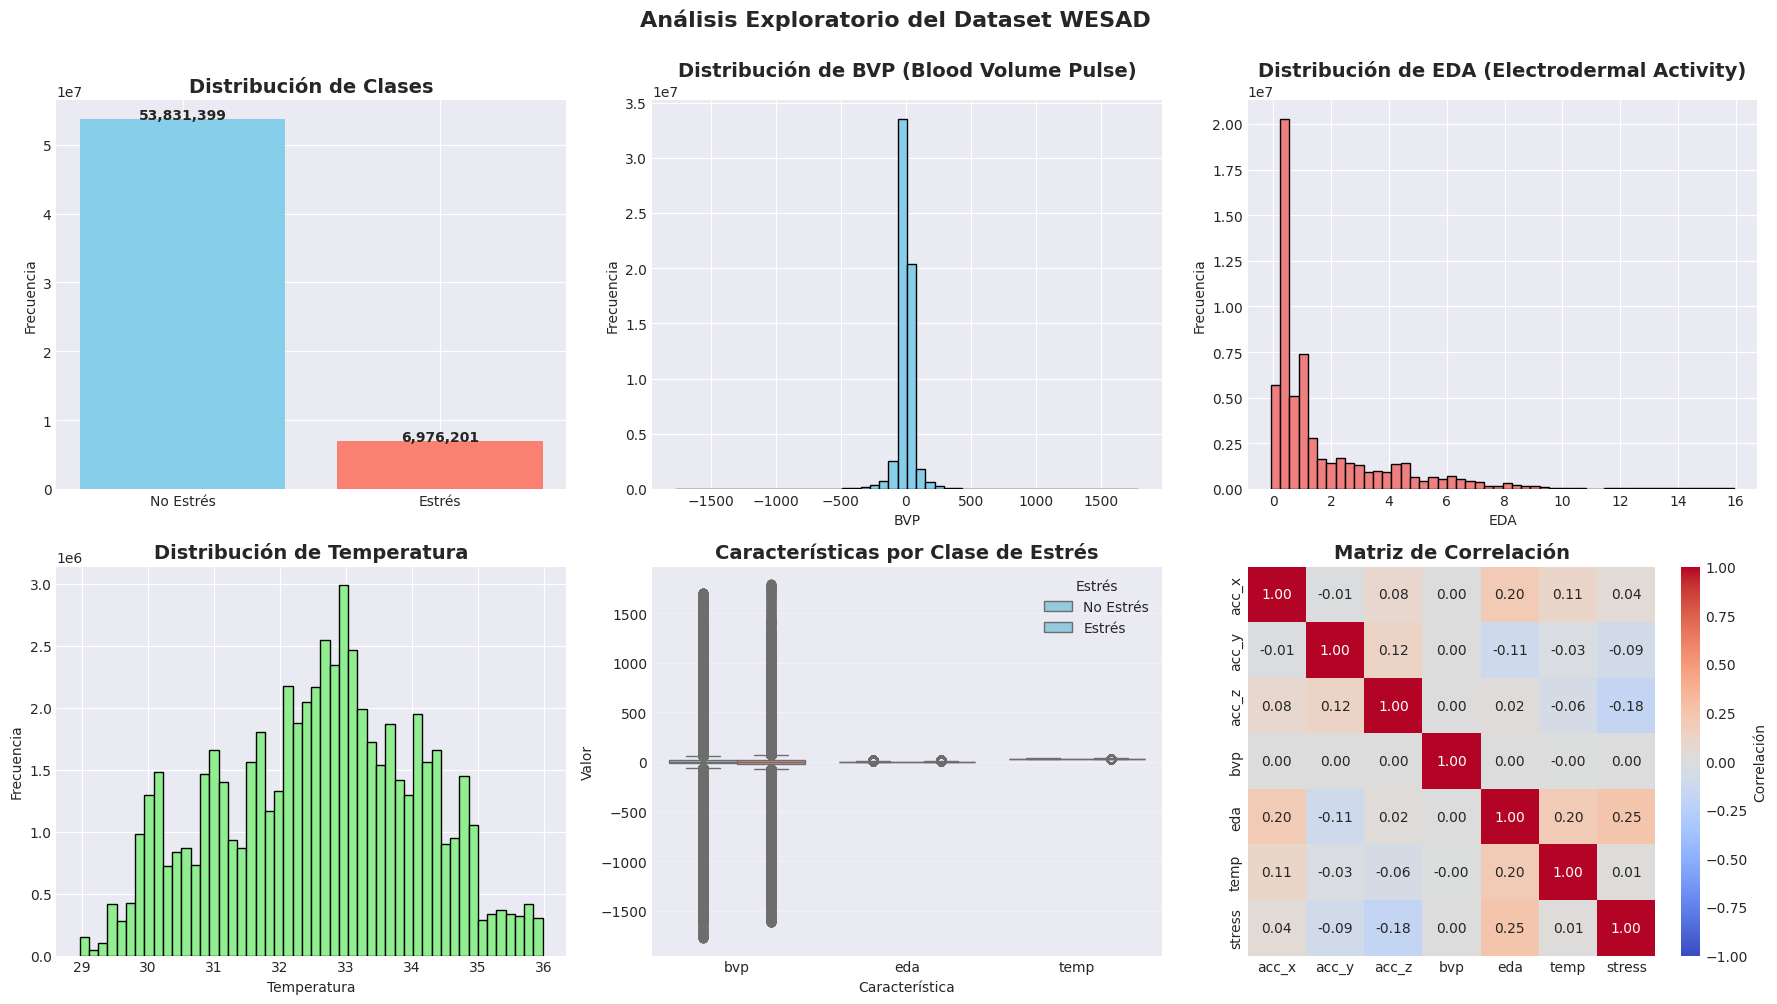


✅ Visualizaciones generadas correctamente


In [ ]:
# Celda de Visualizaciones del Dataset

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribución de clases
class_counts = df_full['stress'].value_counts()
axes[0, 0].bar(['No Estrés', 'Estrés'], class_counts.values, color=['skyblue', 'salmon'])
axes[0, 0].set_title('Distribución de Clases', fontweight='bold', fontsize=14)
axes[0, 0].set_ylabel('Frecuencia')
for i, v in enumerate(class_counts.values):
    axes[0, 0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# 2. Distribución de BVP
axes[0, 1].hist(df_full['bvp'], bins=50, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Distribución de BVP (Blood Volume Pulse)', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('BVP')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Distribución de EDA
axes[0, 2].hist(df_full['eda'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 2].set_title('Distribución de EDA (Electrodermal Activity)', fontweight='bold', fontsize=14)
axes[0, 2].set_xlabel('EDA')
axes[0, 2].set_ylabel('Frecuencia')

# 4. Distribución de Temperatura
axes[1, 0].hist(df_full['temp'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribución de Temperatura', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Temperatura')
axes[1, 0].set_ylabel('Frecuencia')

# 5. Boxplot de características por clase - CORREGIDO
features_to_plot = ['bvp', 'eda', 'temp']
# Preparar datos para boxplot manual
data_no_stress = [df_full[df_full['stress'] == 0][feat].values for feat in features_to_plot]
data_stress = [df_full[df_full['stress'] == 1][feat].values for feat in features_to_plot]

# Crear boxplot con seaborn (más compatible)
import pandas as pd
df_melt = df_full[features_to_plot + ['stress']].melt(id_vars='stress', var_name='Feature', value_name='Value')
import seaborn as sns
sns.boxplot(data=df_melt, x='Feature', y='Value', hue='stress', ax=axes[1, 1], palette=['skyblue', 'salmon'])
axes[1, 1].set_title('Características por Clase de Estrés', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Característica')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend(title='Estrés', labels=['No Estrés', 'Estrés'])
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Matriz de correlación
corr_features = [col for col in df_full.columns if col not in ['subject']]
corr_matrix = df_full[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 2],
            cbar_kws={'label': 'Correlación'}, vmin=-1, vmax=1)
axes[1, 2].set_title('Matriz de Correlación', fontweight='bold', fontsize=14)

plt.suptitle('Análisis Exploratorio del Dataset WESAD', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nVisualizaciones generadas correctamente")

## Paso 2: Reducir Dataset (Window Reduce)

In [ ]:
print("Aplicando window reduce...")
df_reduced = window_reduce(df_full, 700)
print(f"\nDataset reducido: {df_reduced.shape[0]:,} muestras")
print(f"\nBalance de clases:")
print(df_reduced['stress'].value_counts())

Aplicando window reduce...

Dataset reducido: 86,868 muestras

Balance de clases:
stress
0    76887
1     9981
Name: count, dtype: int64


ANÁLISIS DE VALORES QUE INDICAN ESTRÉS

ESTADÍSTICAS POR CLASE:


 BVP

SIN ESTRÉS:
   Media:       -0.0020
   Std:         62.1425
   Min:         -1773.7815
   25%:         -14.7505
   50% (Med):   2.3094
   75%:         16.0743
   Max:         1705.8657

CON ESTRÉS:
   Media:       0.0323
   Std:         84.9531
   Min:         -1618.0987
   25%:         -16.5206
   50% (Med):   0.9034
   75%:         17.8239
   Max:         1789.0859

DIFERENCIA:
   Δ Media:     +0.0343 (-1743.96%)
   ➡️ El estrés AUMENTA BVP

 EDA

SIN ESTRÉS:
   Media:       1.5927
   Std:         2.0220
   Min:         -0.0889
   25%:         0.3186
   50% (Med):   0.6337
   75%:         2.0317
   Max:         14.2420

CON ESTRÉS:
   Media:       3.4152
   Std:         3.6569
   Min:         0.2919
   25%:         1.0355
   50% (Med):   2.1356
   75%:         3.8664
   Max:         15.9458

DIFERENCIA:
   Δ Media:     +1.8225 (+114.43%)
   ➡️ El estrés AUMENTA EDA

 TEMP

SIN ESTRÉS:
   Media:       32.5926
   S

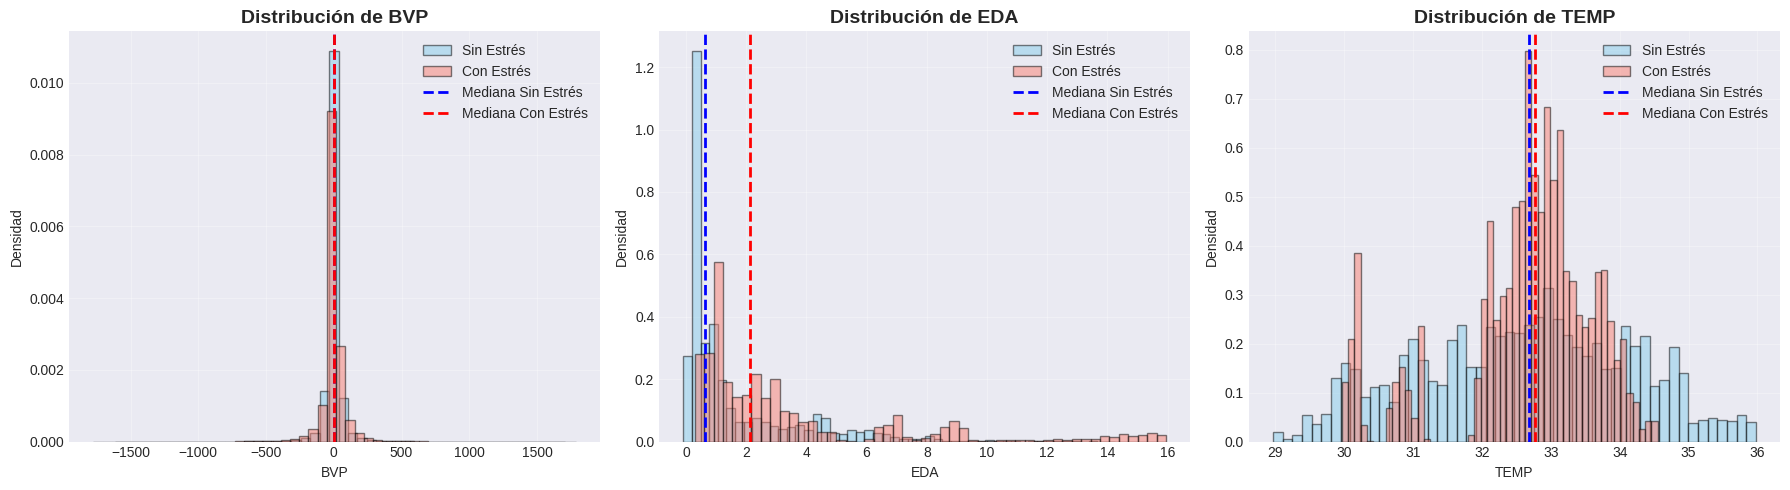


Análisis completado


In [ ]:
# Análisis de valores que indican estrés

print("="*80)
print("ANÁLISIS DE VALORES QUE INDICAN ESTRÉS")
print("="*80)

features_to_analyze = ['bvp', 'eda', 'temp']

# Separar datos por clase
df_no_stress = df_full[df_full['stress'] == 0]
df_stress = df_full[df_full['stress'] == 1]

print("\nESTADÍSTICAS POR CLASE:\n")

for feature in features_to_analyze:
    print(f"\n{'='*60}")
    print(f" {feature.upper()}")
    print(f"{'='*60}")

    # Estadísticas para NO ESTRÉS
    no_stress_stats = df_no_stress[feature].describe()
    print(f"\nSIN ESTRÉS:")
    print(f"   Media:       {no_stress_stats['mean']:.4f}")
    print(f"   Std:         {no_stress_stats['std']:.4f}")
    print(f"   Min:         {no_stress_stats['min']:.4f}")
    print(f"   25%:         {no_stress_stats['25%']:.4f}")
    print(f"   50% (Med):   {no_stress_stats['50%']:.4f}")
    print(f"   75%:         {no_stress_stats['75%']:.4f}")
    print(f"   Max:         {no_stress_stats['max']:.4f}")

    # Estadísticas para ESTRÉS
    stress_stats = df_stress[feature].describe()
    print(f"\nCON ESTRÉS:")
    print(f"   Media:       {stress_stats['mean']:.4f}")
    print(f"   Std:         {stress_stats['std']:.4f}")
    print(f"   Min:         {stress_stats['min']:.4f}")
    print(f"   25%:         {stress_stats['25%']:.4f}")
    print(f"   50% (Med):   {stress_stats['50%']:.4f}")
    print(f"   75%:         {stress_stats['75%']:.4f}")
    print(f"   Max:         {stress_stats['max']:.4f}")

    # Diferencia
    diff_mean = stress_stats['mean'] - no_stress_stats['mean']
    diff_pct = (diff_mean / no_stress_stats['mean']) * 100

    print(f"\nDIFERENCIA:")
    print(f"   Δ Media:     {diff_mean:+.4f} ({diff_pct:+.2f}%)")

    # Interpretación
    if diff_mean > 0:
        print(f"   ➡️ El estrés AUMENTA {feature.upper()}")
    else:
        print(f"   ➡️ El estrés DISMINUYE {feature.upper()}")

# Rangos típicos de estrés
print(f"\n\n{'='*80}")
print("RANGOS TÍPICOS QUE INDICAN ESTRÉS (Percentil 25-75)")
print(f"{'='*80}\n")

for feature in features_to_analyze:
    stress_25 = df_stress[feature].quantile(0.25)
    stress_75 = df_stress[feature].quantile(0.75)
    stress_median = df_stress[feature].median()

    print(f" {feature.upper()}:")
    print(f"   Rango típico de estrés: [{stress_25:.4f} - {stress_75:.4f}]")
    print(f"   Valor típico (mediana): {stress_median:.4f}\n")

# Visualización de distribuciones
print(f"\n{'='*80}")
print("GENERANDO VISUALIZACIÓN COMPARATIVA...")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(features_to_analyze):
    # Histogramas superpuestos
    axes[idx].hist(df_no_stress[feature], bins=50, alpha=0.5, label='Sin Estrés',
                   color='skyblue', density=True, edgecolor='black')
    axes[idx].hist(df_stress[feature], bins=50, alpha=0.5, label='Con Estrés',
                   color='salmon', density=True, edgecolor='black')

    # Líneas verticales para medianas
    axes[idx].axvline(df_no_stress[feature].median(), color='blue',
                     linestyle='--', linewidth=2, label='Mediana Sin Estrés')
    axes[idx].axvline(df_stress[feature].median(), color='red',
                     linestyle='--', linewidth=2, label='Mediana Con Estrés')

    axes[idx].set_title(f'Distribución de {feature.upper()}',
                       fontweight='bold', fontsize=14)
    axes[idx].set_xlabel(feature.upper())
    axes[idx].set_ylabel('Densidad')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnálisis completado")

---

## ENTRENAMIENTO OPTIMIZADO CON HIPERPARÁMETROS AVANZADOS

Ejecutar el pipeline completo con todos los modelos optimizados


EJECUTANDO ENTRENAMIENTO OPTIMIZADO
Descargando datos desde Kaggle (esto puede tardar)...

Cargando 15 sujetos...
Procesando S2...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S3...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S4...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S5...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S6...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S7...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S8...
Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Procesando S9...
Using Colab cache for faster access to the

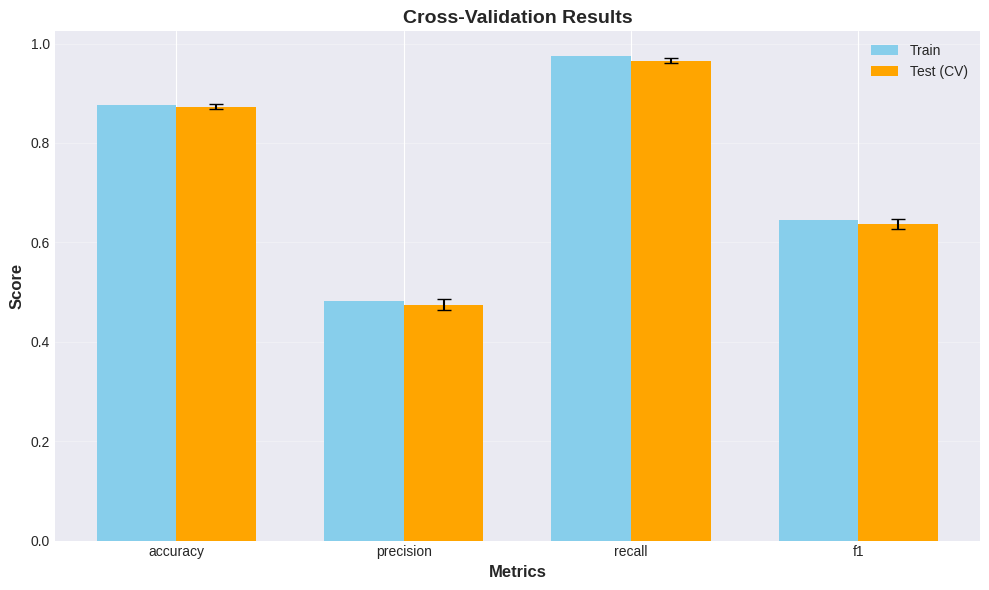


Entrenando en train completo...

Evaluando en test...

Resultados en Test:
   Accuracy:  0.8724
   Precision: 0.4730
   Recall:    0.9694
   F1-Score:  0.6358
   ROC-AUC:   0.9685

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     15378
           1       0.47      0.97      0.64      1996

    accuracy                           0.87     17374
   macro avg       0.73      0.91      0.78     17374
weighted avg       0.94      0.87      0.89     17374



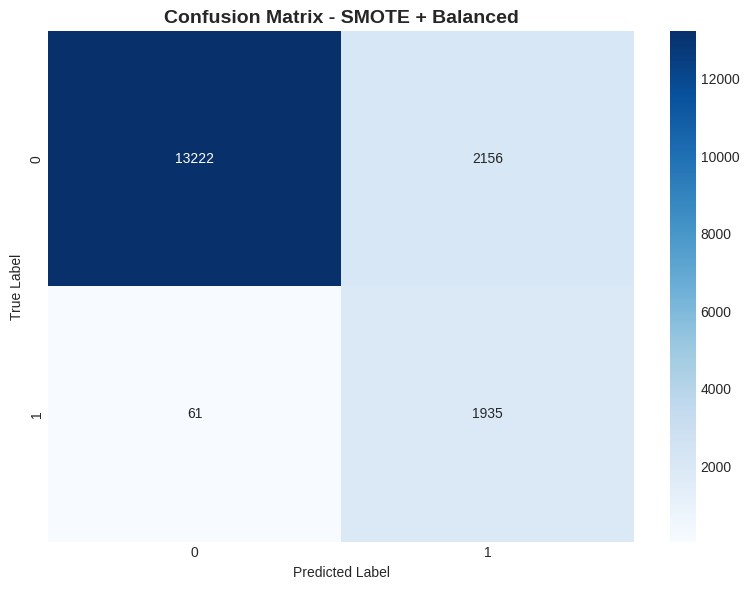

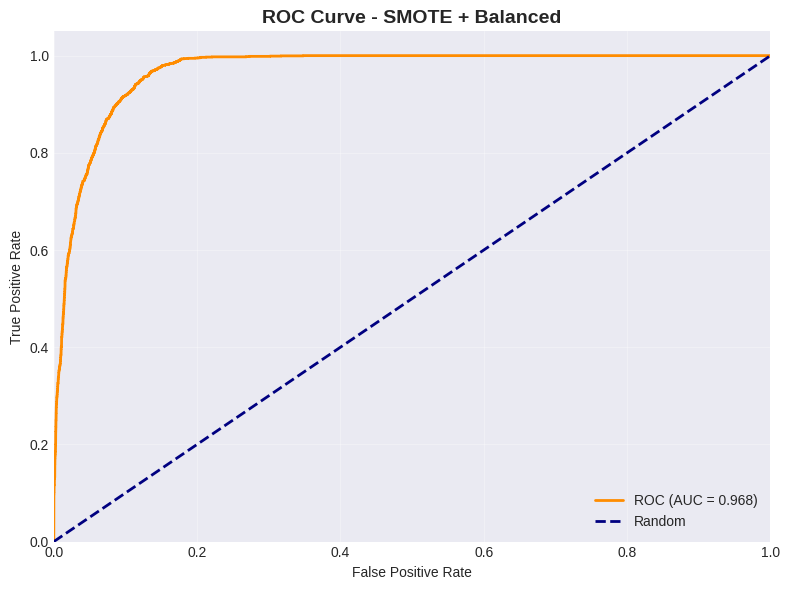


Analizando overfitting para SMOTE + Balanced...

ANÁLISIS DE OVERFITTING - SMOTE + Balanced

Métricas Train vs Test:
  Métrica  Train   Test Diferencia
 Accuracy 0.8723 0.8724    -0.0001
Precision 0.4729 0.4730    -0.0001
   Recall 0.9751 0.9694     0.0056
 F1-Score 0.6369 0.6358     0.0012
  ROC-AUC 0.9713 0.9685     0.0028

Diagnóstico de Overfitting:
   Accuracy: Buen ajuste (diferencia: -0.0001)
   Precision: Buen ajuste (diferencia: -0.0001)
   Recall: Buen ajuste (diferencia: 0.0056)
   F1-Score: Buen ajuste (diferencia: 0.0012)
   ROC-AUC: Buen ajuste (diferencia: 0.0028)

Generando gráfico comparativo (learning curves desactivadas)...


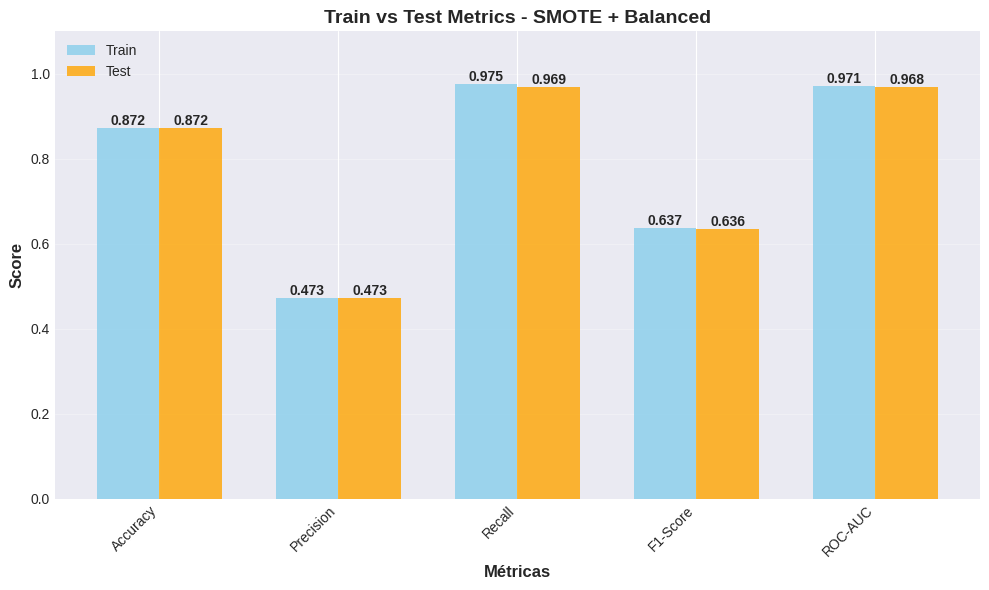


Modelo: SMOTE + Delta Step

Cross-Validation...

Resultados CV:
   ACCURACY:
      Train: 0.8744 (±0.0025)
      Test:  0.8707 (±0.0030)
   PRECISION:
      Train: 0.4773 (±0.0051)
      Test:  0.4694 (±0.0058)
   RECALL:
      Train: 0.9750 (±0.0020)
      Test:  0.9623 (±0.0080)
   F1:
      Train: 0.6409 (±0.0048)
      Test:  0.6310 (±0.0055)


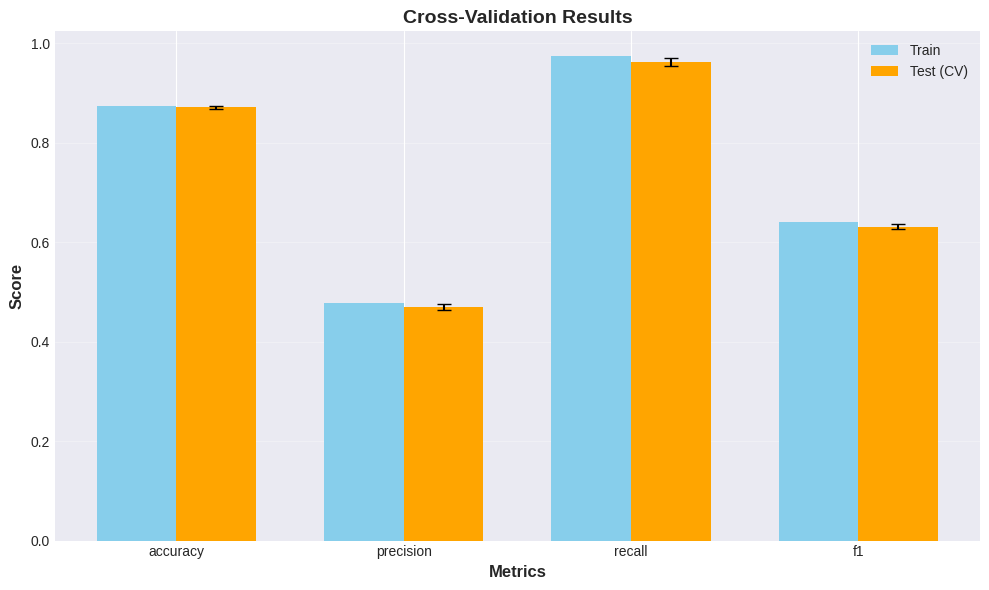


Entrenando en train completo...

Evaluando en test...

Resultados en Test:
   Accuracy:  0.8725
   Precision: 0.4729
   Recall:    0.9604
   F1-Score:  0.6337
   ROC-AUC:   0.9686

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     15378
           1       0.47      0.96      0.63      1996

    accuracy                           0.87     17374
   macro avg       0.73      0.91      0.78     17374
weighted avg       0.93      0.87      0.89     17374



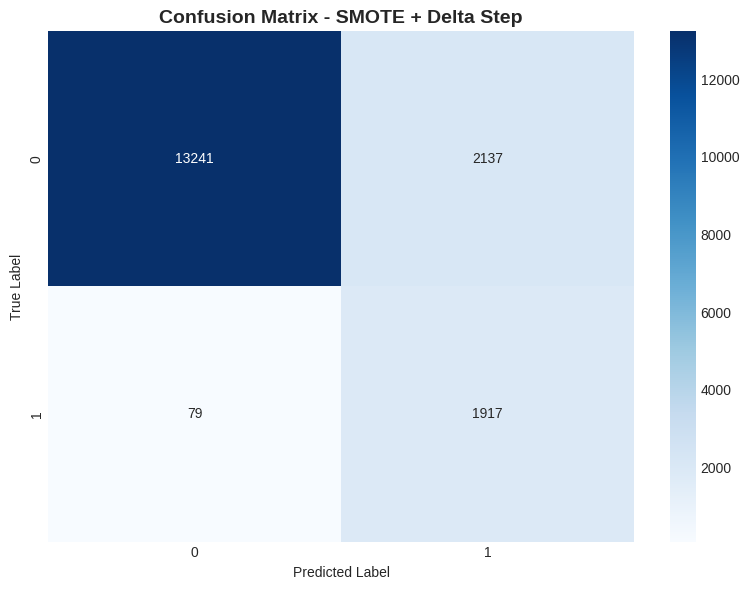

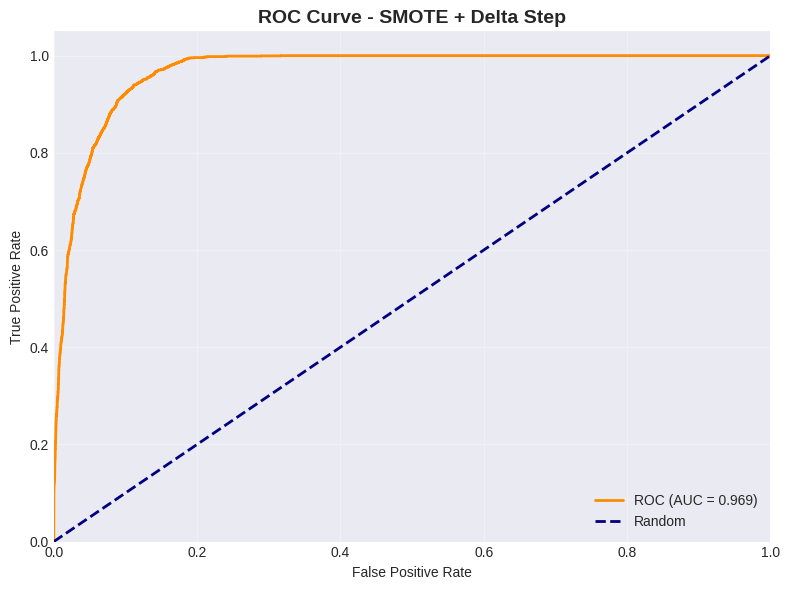


Analizando overfitting para SMOTE + Delta Step...

ANÁLISIS DE OVERFITTING - SMOTE + Delta Step

Métricas Train vs Test:
  Métrica  Train   Test Diferencia
 Accuracy 0.8736 0.8725     0.0011
Precision 0.4755 0.4729     0.0026
   Recall 0.9738 0.9604     0.0134
 F1-Score 0.6390 0.6337     0.0053
  ROC-AUC 0.9708 0.9686     0.0022

Diagnóstico de Overfitting:
   Accuracy: Buen ajuste (diferencia: 0.0011)
   Precision: Buen ajuste (diferencia: 0.0026)
   Recall: Buen ajuste (diferencia: 0.0134)
   F1-Score: Buen ajuste (diferencia: 0.0053)
   ROC-AUC: Buen ajuste (diferencia: 0.0022)

Generando gráfico comparativo (learning curves desactivadas)...


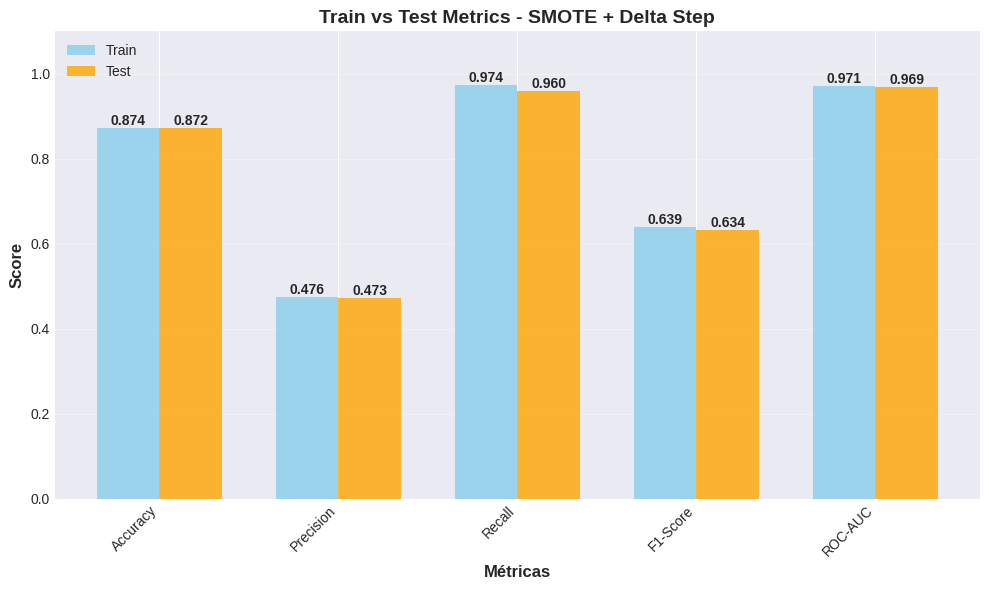


Modelo: Scale Weight Agresivo

Cross-Validation...

Resultados CV:
   ACCURACY:
      Train: 0.8530 (±0.0018)
      Test:  0.8498 (±0.0036)
   PRECISION:
      Train: 0.4385 (±0.0030)
      Test:  0.4325 (±0.0058)
   RECALL:
      Train: 0.9945 (±0.0009)
      Test:  0.9845 (±0.0037)
   F1:
      Train: 0.6086 (±0.0029)
      Test:  0.6010 (±0.0056)


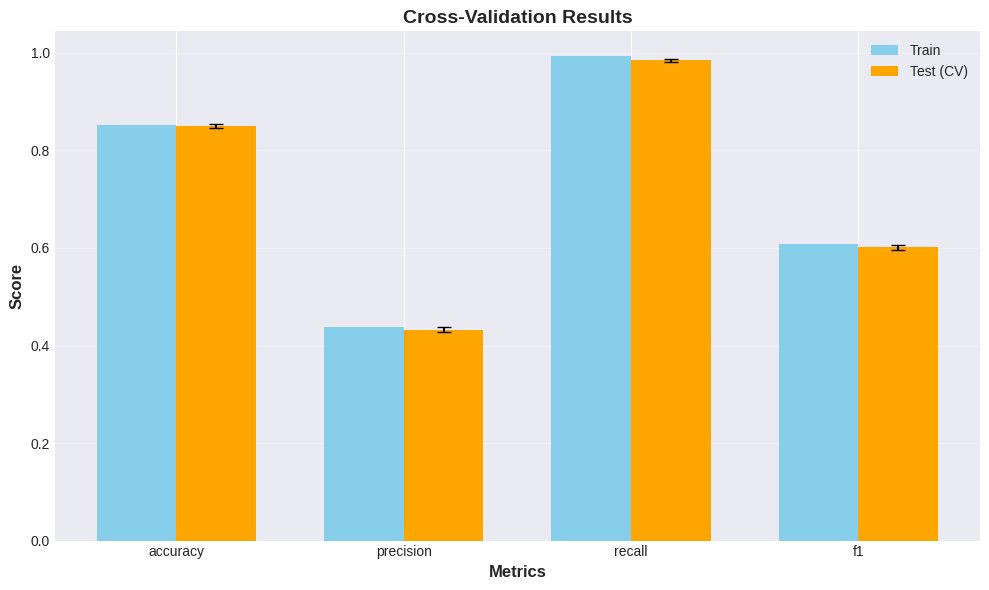


Entrenando en train completo...

Evaluando en test...

Resultados en Test:
   Accuracy:  0.8521
   Precision: 0.4366
   Recall:    0.9910
   F1-Score:  0.6062
   ROC-AUC:   0.9703

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     15378
           1       0.44      0.99      0.61      1996

    accuracy                           0.85     17374
   macro avg       0.72      0.91      0.76     17374
weighted avg       0.93      0.85      0.87     17374



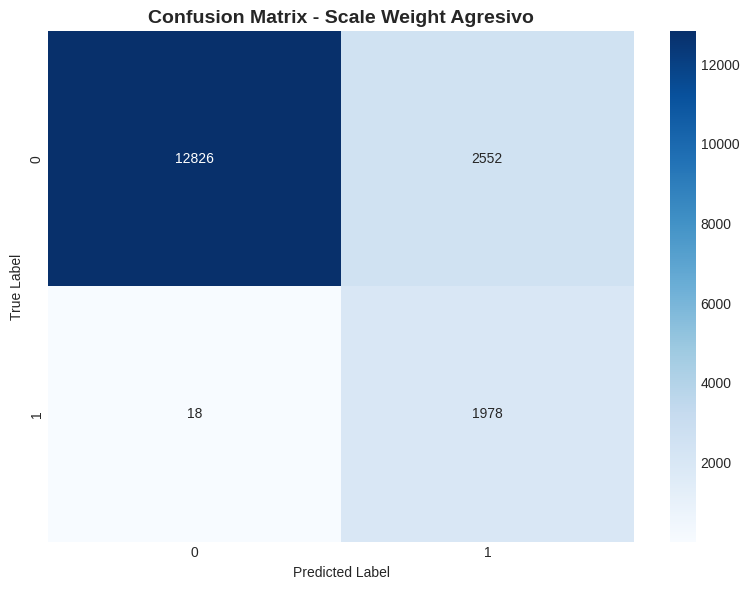

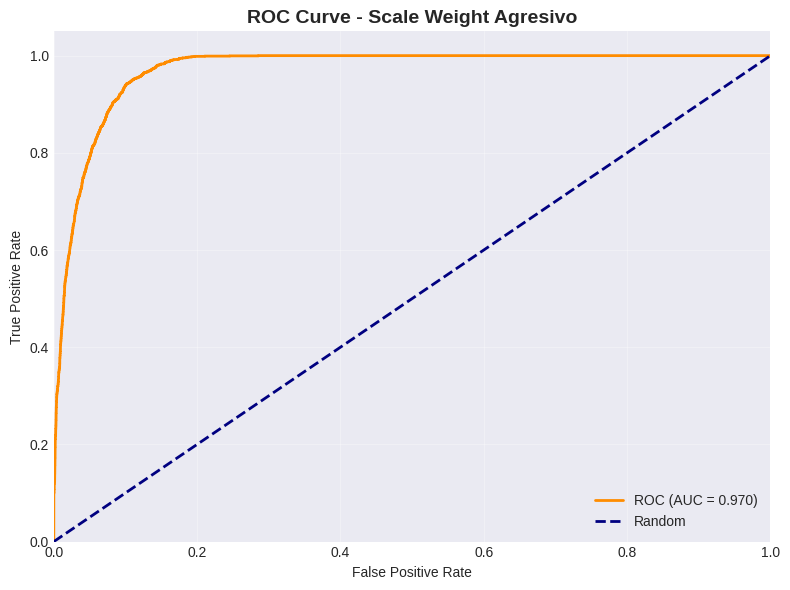


Analizando overfitting para Scale Weight Agresivo...

ANÁLISIS DE OVERFITTING - Scale Weight Agresivo

Métricas Train vs Test:
  Métrica  Train   Test Diferencia
 Accuracy 0.8525 0.8521     0.0005
Precision 0.4377 0.4366     0.0010
   Recall 0.9945 0.9910     0.0035
 F1-Score 0.6078 0.6062     0.0016
  ROC-AUC 0.9730 0.9703     0.0027

Diagnóstico de Overfitting:
   Accuracy: Buen ajuste (diferencia: 0.0005)
   Precision: Buen ajuste (diferencia: 0.0010)
   Recall: Buen ajuste (diferencia: 0.0035)
   F1-Score: Buen ajuste (diferencia: 0.0016)
   ROC-AUC: Buen ajuste (diferencia: 0.0027)

Generando gráfico comparativo (learning curves desactivadas)...


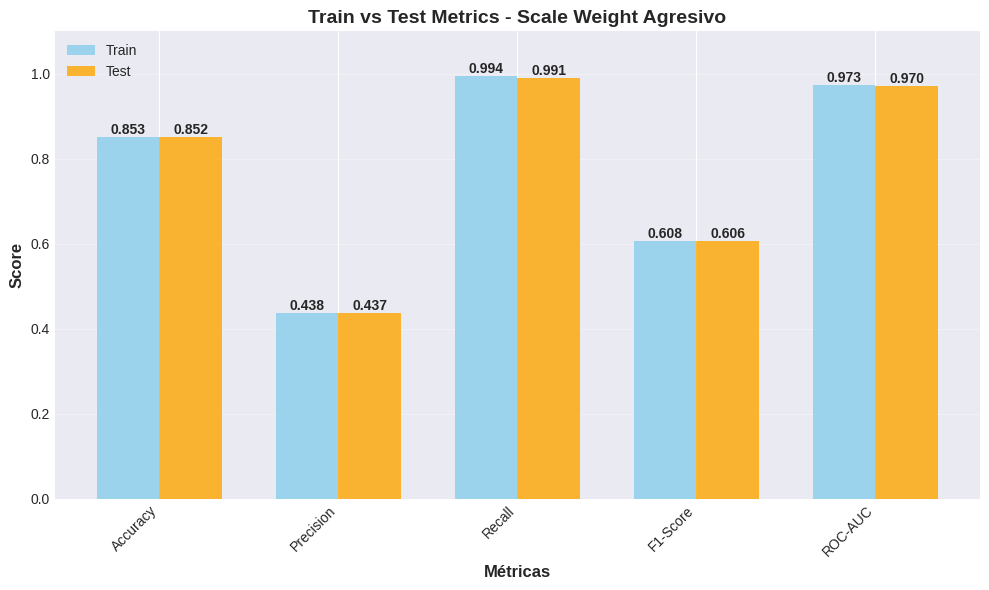


COMPARACIÓN DE MODELOS


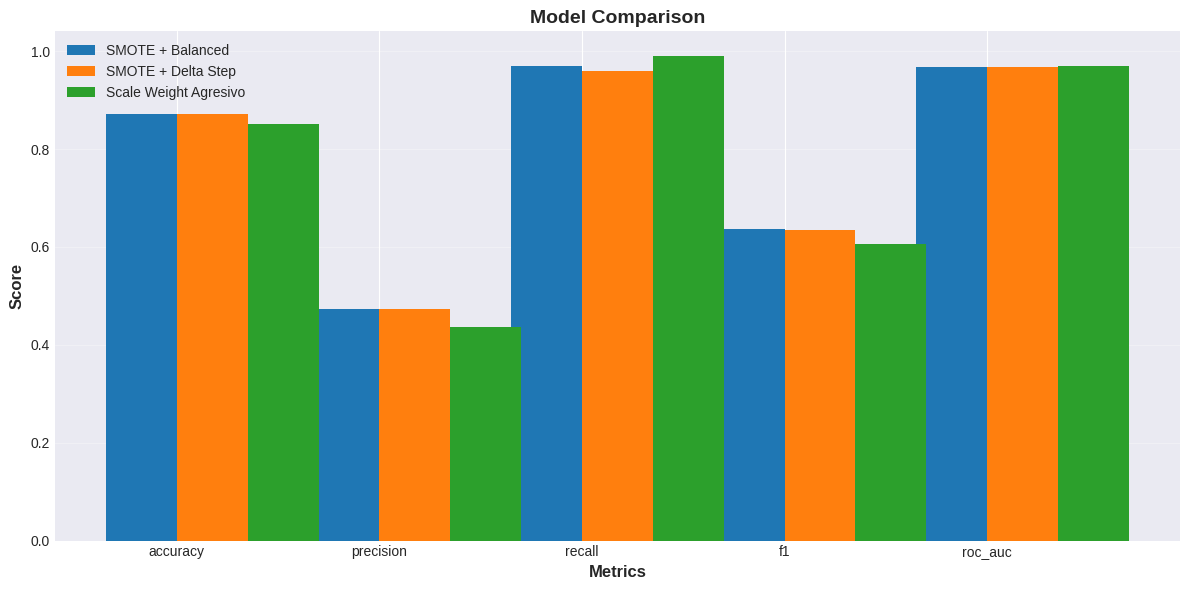


Mejor modelo: SMOTE + Balanced
   F1-Score: 0.6358
   Recall:   0.9694
   Accuracy: 0.8724

Guardando mejor modelo...
Modelo guardado en: best_wesad_xgboost_con_smote_model_v2.pkl

PRUEBAS FINALES CON EL MEJOR MODELO

Probando predicciones:

CORRECTO Relajado:
   Entrada: BVP=0.1, EDA=0.5, Temp=32.0°C
   Predicción: SIN ESTRÉS (confianza: 99.48%)
   Probabilidades: Sin estrés=99.48%, Con estrés=0.52%
   Esperado: SIN ESTRÉS

CORRECTO Normal:
   Entrada: BVP=0.3, EDA=2.0, Temp=33.5°C
   Predicción: SIN ESTRÉS (confianza: 99.85%)
   Probabilidades: Sin estrés=99.85%, Con estrés=0.15%
   Esperado: SIN ESTRÉS

CORRECTO Estrés moderado:
   Entrada: BVP=0.5, EDA=8.0, Temp=34.5°C
   Predicción: CON ESTRÉS (confianza: 84.48%)
   Probabilidades: Sin estrés=15.52%, Con estrés=84.48%
   Esperado: CON ESTRÉS

CORRECTO Estrés alto:
   Entrada: BVP=0.6, EDA=12.0, Temp=35.5°C
   Predicción: CON ESTRÉS (confianza: 84.48%)
   Probabilidades: Sin estrés=15.52%, Con estrés=84.48%
   Esperado: CON ESTRÉS

In [ ]:
###################
# Funcion: run_optimized_training
# Parametros: df (DataFrame) - Dataset reducido con window reduce aplicado
# Salida: tuple - (resultados, pipelines, mejor_modelo) con los resultados del entrenamiento
# Proposito: Ejecutar el pipeline completo de entrenamiento con hiperparámetros optimizados
###################
def run_optimized_training(df):
    """Ejecuta el pipeline completo con hiperparámetros optimizados."""
    # Casos de prueba para evaluación final
    test_cases = [
        ("Relajado", 0.1, 0.5, 32.0, 0),
        ("Normal", 0.3, 2.0, 33.5, 0),
        ("Estrés moderado", 0.5, 8.0, 34.5, 1),
        ("Estrés alto", 0.6, 12.0, 35.5, 1),
        ("Estrés extremo", 0.8, 15.0, 36.0, 1),
    ]

    # Ejecutar pipeline completo con todos los modelos optimizados
    results, pipelines, best_model_name = run_evaluation_pipeline(
        df,
        target_col='stress',
        features=['bvp', 'eda', 'temp'],
        use_smote=False,  # Los modelos se configuran internamente
        perform_cv=True,
        include_learning_curves=False,  # Desactivado por tiempo
        save_best_model=True,
        test_cases=test_cases
    )

    return results, pipelines, best_model_name

# EJECUTAR ENTRENAMIENTO OPTIMIZADO
print("\n" + "="*80)
print("EJECUTANDO ENTRENAMIENTO OPTIMIZADO")
print("="*80)

# Verificar si tenemos datos en cache
try:
    df_full = pd.read_pickle('df_full_cache.pkl')
    print("Datos cargados desde cache")
except:
    print("Descargando datos desde Kaggle (esto puede tardar)...")
    df_full = load_all_subjects(CONFIG['subjects'])
    df_full.to_pickle('df_full_cache.pkl')
    print("Datos guardados en cache")

# Aplicar window reduce
df_reduced = window_reduce(df_full, CONFIG['sampling_rate_hz'], CONFIG['window_seconds'])

# Ejecutar el pipeline optimizado
results_optimizados, pipelines_optimizados, mejor_modelo = run_optimized_training(df_reduced)

print("\n" + "="*80)
print("ENTRENAMIENTO OPTIMIZADO COMPLETADO")
print("="*80)